# Convex Empirical Risk Minimization
 
[Last time](20-perceptron.ipynb), we studied the binary classification problem. In this problem, we assume that we have a *feature matrix* $\mathbf{X} \in \mathbb{R}^{n\times p}$. Each row of this feature matrix gives the predictor data (features) for each of $n$ total observations: 

$$
\mathbf{X} = \left[\begin{matrix} & - & \mathbf{x}_1 & - \\ 
& - & \mathbf{x}_2 & - \\ 
& \vdots & \vdots & \vdots \\ 
& - & \mathbf{x}_{n} & - \end{matrix}\right] 
$$

We also have a *target vector* $\mathbf{y} \in \{0,1\}^n$. [For convenience, we will continue to assume that the final column of $\mathbf{X}$ is a column of 1s; i.e. $x_{ip} = 1$ for all $i = 1,\ldots,n$.]{.aside} Here's an example of how our training data might look: 


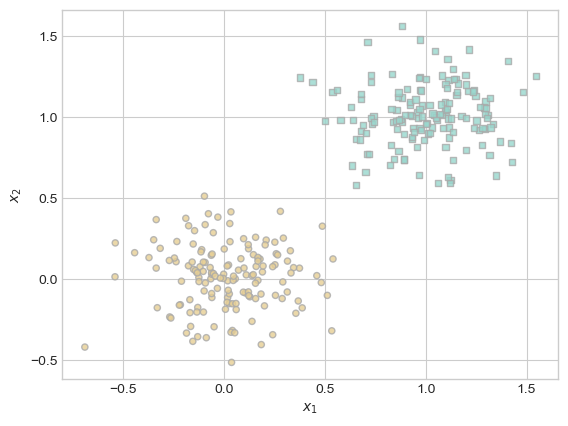

In [25]:
#| fig-cap: '300 data points in the 2d plane, each of which has one of two labels.'
#| fig-cap-location: margin
#| label: fig-scatter
#| code-fold: true 

import torch
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = classification_data(n_points = 300, noise = 0.2)

def plot_classification_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -1, vmax = 2, alpha = 0.8, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1)
X, y = classification_data()
plot_classification_data(X, y, ax)

We continue to study the *linear* classification problem. We will find a vector of *weights* $\mathbf{w}$ with the property that the hyperplane defined by the equation 

$$
\langle \mathbf{w}, \mathbf{x} \rangle = 0
$$

approximately separates the two classes. 

## Modeling Choices

Once we have chosen linear models as our tool, we can specify a model for the binary classification task by making two additional choices: 

1. **Loss**: How will we measure the success of the model in distinguishing the two classes?
2. **Optimizer**: What algorithm will we use in order to minimize the loss? 

What choices did we make in the context of the perceptron?

The **loss** function was the misclassification rate. If we let $s_i = \langle \mathbf{w}, \mathbf{x}_i\rangle$, then we can write the loss like this:  [Here, the term $2y_i - 1$ transforms a $y_i$ with values in $\{0,1\}$ into one with values in $\{-1,1\}$.]{.aside}

$$
L(\mathbf{w}) = \frac{1}{n}\sum_{i = 1}^n \mathbb{1}[s_i (2y_i-1) < 0]
$$

The **optimizer** we used to minimize the loss was the perceptron update, in which we picked a random point $i$ and then performed the update

[If $i$ is correctly classified (i.e. if $s_i(2 y_i - 1) > 0$), then the second term zeros out and nothing happens.]{.aside}
$$
\mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} + \mathbb{1}[s_i (2y_i-1) < 0]y_i \mathbf{x}_i
$$

However, as we saw, this doesn't actually work that well. There are two problems: 

1. Our problem with the **optimizer** was that this update won't actually converge if the data is not linearly separable. Maybe we could choose a better optimizer that would converge? 
2. Unfortunately not -- as we saw last time, the very problem of minimizing $L(\mathbf{w})$ is NP-hard. This is a problem with the **loss function itself**. 

So, how could we choose a *better loss function* that would allow us to create efficient algorithms? 

## Convex Functions

Let's start by visualizing a single term of the perceptron loss function. We'll view this as a function of the score $s$ and the true target value $y$: 

$$
\ell(s, y) = \mathbb{1}[s (2y-1) < 0]\;. 
$$

We'll call this the *0-1 loss function*. Here's a plot of this function for each of the two possible values of $y$: 


In [26]:
#| echo: false

import warnings


In [27]:
#---
def zero_one_loss(s, y): 
    return 1*(s*(2*y-1)< 0)
#---

# or 
# hinge_loss = lambda s, y: 1*(s*(2*y-1) < 0)

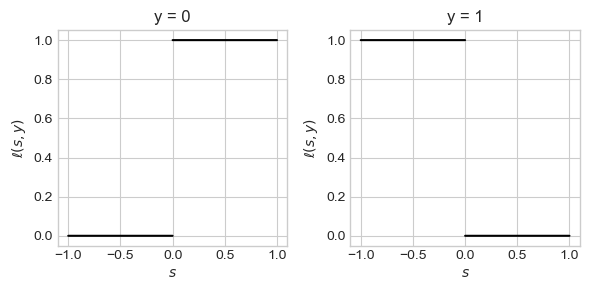

In [28]:
#| fig-cap: 'The 0-1 loss function.'
#| fig-cap-location: margin
#| label: fig-0-1-loss
#| code-fold: true

from matplotlib import pyplot as plt 
plt.style.use('seaborn-v0_8-whitegrid')
# plt.rcParams["figure.figsize"] = (10, 4)

def plot_loss(loss_fun, show_line = False):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        fig, axarr = plt.subplots(1, 2, figsize = (6, 3)) 
        s = torch.linspace(-1, 1, 10001)

        for j in range(2):
            y = [0, 1][j]
            axarr[j].set_title(f"y = {y}")
            axarr[j].set(xlabel = r"$s$", 
                        ylabel = r"$\ell(s, y)$")
            
            ix1 = s < 0
            axarr[j].plot(s[ix1], loss_fun(s[ix1], y), color = "black")
            ix2 = s > 0
            axarr[j].plot(s[ix2], loss_fun(s[ix2], y), color = "black")

            if show_line: 
                s1 = torch.tensor([-0.7])
                s2 = torch.tensor([0.9])

                axarr[j].plot([s1, s2], [loss_fun(s1, y), loss_fun(s2, y)], color = "darkgrey", linestyle = "--")

        plt.tight_layout()
        return fig, axarr

fig, axarr = plot_loss(loss_fun = zero_one_loss, show_line = False)

Surprsingly, the problem with this loss function $\ell$ is that we can "draw lines under the function." What this means is that we can pick two points on the graph of the function, connect them with a line, and find that the line lies *under* the graph of the function in some regions: 


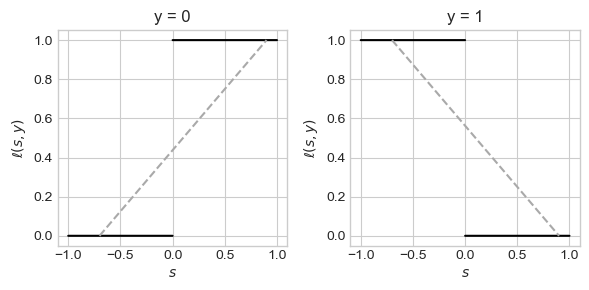

In [29]:
#| fig-cap: 'The 0-1 loss function with a line demonstrating that this function is nonconvex.'
#| fig-cap-location: margin
#| label: fig-0-1-loss-nonconvex
#| code-fold: true

fig, axarr = plot_loss(loss_fun = zero_one_loss, show_line = True)

Surprisingly, this specific geometric property is what's blocking us from achieving performant searchability for the problem of finding $\mathbf{w}$.  

## Convex Loss Functions

In order to develop convex loss functions, we need to define two concepts: 

::: {.callout-note}
::: {#def-convex-set} 

A set $S \subseteq \mathbb{R}^n$ is *convex* if, for any two points $\mathbf{z}_1, \mathbf{z}_2 \in S$ and for any $\lambda \in [0,1]$, the point $\mathbf{z} = \lambda \mathbf{z}_1 + (1-\lambda) \mathbf{z}_2$ is also an element of $S$. 

::: 
:::

We also need to define convex *functions*: 


::: {.callout-note}
::: {#def-convex-function} 

## Convex Functions

Let $S \subseteq \mathbb{R}^n$ be convex. A function $f:S \rightarrow \mathbb{R}$ is *convex* if, for any $\lambda \in \mathbb{R}$ and any two points $\mathbf{z}_1, \mathbf{z}_2 \in S$, we have 

$$
f(\lambda \mathbf{z}_1 + (1-\lambda)\mathbf{z}_2) \leq \lambda f( \mathbf{z}_1 ) + (1-\lambda)f(\mathbf{z}_2)\;.
$$

The function $f$ is *strictly convex* if the inequality is strict: for all $\lambda$, $\mathbf{z}_1$, and $\mathbf{z}_2$, 

$$
f(\lambda \mathbf{z}_1 + (1-\lambda)\mathbf{z}_2) < \lambda f( \mathbf{z}_1 ) + (1-\lambda)f(\mathbf{z}_2)\;.
$$

:::
:::

Roughly, a convex function is "bowl-shaped," in the sense that any line connecting two points on its graph must lie above the graph.  The most familiar example of a convex function is our good friend the convex parabola: 


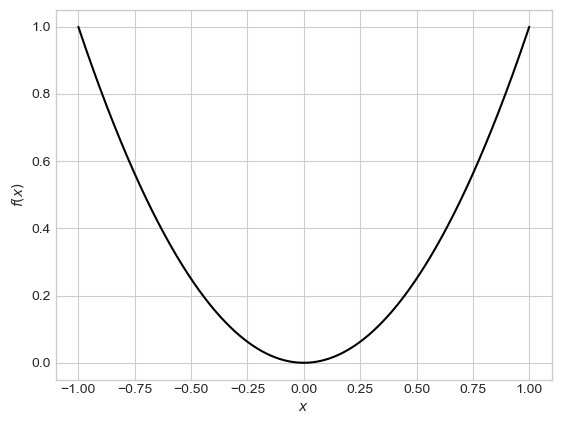

In [30]:
#| fig-cap: 'The convex parabola $f(x) = x^2$'
#| fig-cap-location: margin
#| label: fig-parabola
#| code-fold: true

x = torch.linspace(-1, 1, 10001)
y = x**2

plt.plot(x, y, color = "black")
labs = plt.gca().set(xlabel = r"$x$", ylabel = r"$f(x)$")

Note that any straight line connecting two points on this graph always stays above the graph of the parabola. As we saw above, the 0-1 loss function $\ell(s, y) = \mathbb{1}[s(2y-1)<0]$ does not have this property. 

We can also define convex functions to replace the nonconvex 0-1 loss function from earlier. Here's an example, which is usually called the *hinge loss*, which is defined by the formula 

$$
\ell(s, y) = y \max \{0, s\} + (1 - y) \max\{0, -s\}\;.
$$


In [31]:
#---

def hinge_loss(s, y):
    first_term  =  y    * (torch.max(torch.zeros_like(s),  s))  
    second_term = (1-y) * (torch.max(torch.zeros_like(s), -s))
    return first_term + second_term

# or
# hinge_loss = lambda s, y: y * (torch.max(torch.zeros_like(s), s))  + (1-y) * (torch.max(torch.zeros_like(s), -s))
#---

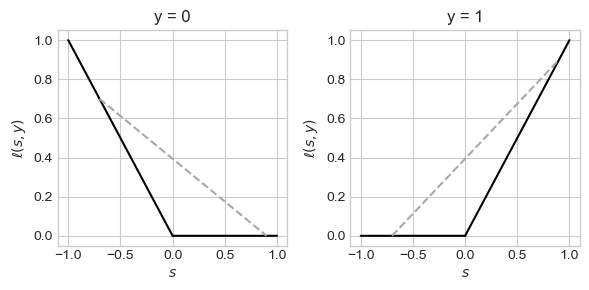

In [32]:
#| fig-cap: 'The hinge loss function.'
#| fig-cap-location: margin
#| label: fig-hinge-loss
#| code-fold: true

fig, axarr = plot_loss(loss_fun = hinge_loss, show_line = True)

The hinge loss is not strictly convex and is not even everywhere differentiable! Despite this, the fact that it is convex has made it a modern workhorse of machine learning. The support vector machine (SVM) operates by minimizing the hinge loss. The "Rectified Linear Unit" (ReLU) is a mainstay of modern deep learning--and is just another name for the hinge loss. 

An even handier loss function for our purposes is the sigmoid binary cross entropy, which is defined by the formula 
[In this formula, $\sigma(s) = \frac{1}{1 + e^{-s}}$ is the logistic sigmoid function.]{.aside}
$$
\begin{aligned}
\ell(s, y) &=  -y \log \sigma(s) - (1-y)\log (1-\sigma(s))\;,
\end{aligned}
$$


In [33]:
#---
def sig(s):
    return 1 / (1 + torch.exp(-s))

def binary_cross_entropy(s, y):
    return -(y * sig(s).log() + (1 - y)*(1-sig(s)).log())
#---

# or 
# sig = lambda s: 1 / (1 + torch.exp(-s))
# binary_cross_entropy = lambda s, y: -(y * sig(s).log() + (1 - y)*(1-sig(s)).log())

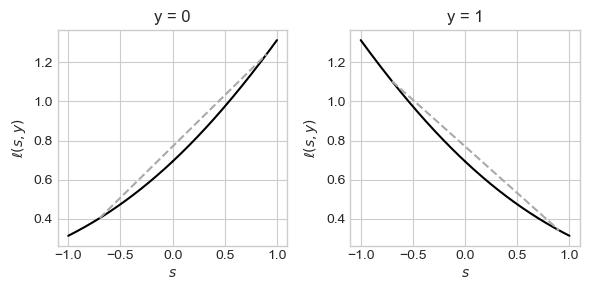

In [34]:
#| fig-cap: 'The binary cross-entropy loss function.'
#| fig-cap-location: margin
#| label: fig-cross-entropy-loss
#| code-fold: true

sig = lambda s: 1 / (1 + torch.exp(-s))
binary_cross_entropy = lambda s, y: -(y * sig(s).log() + (1 - y)*(1-sig(s)).log())
fig, axarr = plot_loss(loss_fun = binary_cross_entropy, show_line = True)

This function is also convex, and has the considerable benefit of being everywhere differentiable. 

We intentionally formulated our definition of convexity for functions of many variables. Here is a convex function $f:\mathbb{R}^2 \rightarrow \mathbb{R}$. 


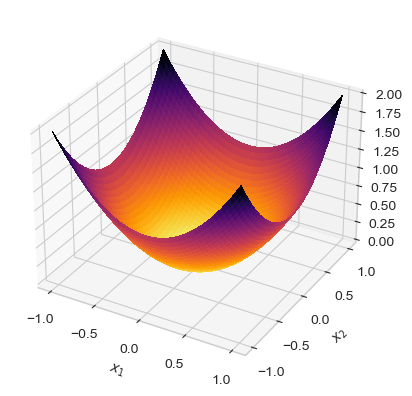

In [35]:
#| fig-cap: 'A convex quadratic function of two variables.'
#| fig-cap-location: margin
#| label: fig-quadratic-3d
#| code-fold: true

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

x = torch.linspace(-1, 1, 1001)[:, None]
y = torch.linspace(-1, 1, 1001)[None, :]

z = x**2 + y**2

ax.plot_surface(x, y, z, cmap="inferno_r",
                       linewidth=0, antialiased=False)

labs = ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

You could imagine trying to draw a straight line between two points on the graph of this function -- the line would always be above the graph. When thinking about convexity in many variables, it is often sufficient to imagine a bowl-shaped function like this one. 


## Convex Empirical Risk Minimization

We are now ready to define the primary framework in which we will conduct supervised machine learning: convex empirical risk minimization. 

::: {.callout-note}
::: {#def-empirical-risk}

## Empirical Risk Minimization

Given a loss function $\ell:\mathbb{R}\times \{0,1\} \rightarrow \mathbb{R}$, a feature matrix $\mathbb{X} \in \mathbb{R}^{n\times p}$, a target vector $\mathbf{y}$, and a parameter vector $\mathbf{w} \in \mathbb{R}^p$, the *empirical risk of $\mathbf{w}$* is 

$$
\begin{aligned}
L(\mathbf{w}) = \frac{1}{n}\sum_{i = 1}^n \ell(s_i, y_i), \quad&\text{where }s_i = \langle \mathbf{w}, \mathbf{x}_i\rangle\;.
\end{aligned}
$$

The *empirical risk minimization problem* is to find the value of $\mathbf{w}$ that makes $L(\mathbf{w})$ smallest: 

$$
\DeclareMathOperator*{\argmin}{argmin}
\begin{aligned}
\hat{\mathbf{w}} &= \argmin_{\mathbf{w}} L(\mathbf{w})  \\ 
                 &= \argmin_{\mathbf{w}} \frac{1}{n}\sum_{i = 1}^n \ell(s_i, y_i) \\ 
                 &= \argmin_{\mathbf{w}} \frac{1}{n}\sum_{i = 1}^n \ell(\langle \mathbf{w}, \mathbf{x}_i\rangle, y_i)\;.
\end{aligned}
$${#eq-ERM}

:::
:::

::: {.callout-note}
::: {#prp-sum-of-convex}

## Convex $\ell$ means convex $L$

If the per-observation loss function $\ell:\mathbb{R}\times \{0,1\} \rightarrow \mathbb{R}$ is convex in its first argument, then the empirical risk $L(\mathbf{w})$ is convex as a function of $\mathbf{w}$. 

:::
:::

The proof of @prp-sum-of-convex involves some elementary properties of convex functions: 

1. If $f(\mathbf{z})$ is convex as a function of $\mathbf{z}$, then $g(\mathbf{z}) = f(\mathbf{A}\mathbf{z'})$ is also convex as a function of $\mathbf{z}'$, provided that all the dimensions work out. 
2. Any finite sum of convex functions is convex. 

So, we know that if we choose $\ell$ to be convex in the score function, then the entire empirical risk $L$ will be convex as a function of the weight vector $\mathbf{w}$. 

Why do we care? 

## Convex Functions Have  Global Minimizers

We want to solve the empirical risk minimization problem: 

$$
\DeclareMathOperator*{\argmin}{argmin}
\begin{aligned}
\hat{\mathbf{w}} &= \argmin_{\mathbf{w}} L(\mathbf{w}).
\end{aligned}
$$

We might ask ourselves a few questions about this problem: 

1. **Existence**: Does there exist *any* choice of $\mathbf{w}$ that achieves a minimizing value for this function? 
2. **Uniqueness**: Is this choice of $\mathbf{w}$ unique, or are there multiple candidates?
3. **Searchability**: are there algorithms which are guaranteed to (a) terminate and (b) not get "trapped" at a bad solution?

Answering these questions precisely requires a bit more math: 

::: {.callout-note} 
::: {#def-minimizers} 

## Local and Global Minimizers
 
A point $\mathbf{z}\in S$ is a *global minimizer* of the function $f:S \rightarrow \mathbb{R}$ if $f(\mathbf{z}) \leq f(\mathbf{z}')$ for all $\mathbf{z}' \in S$. 

A point $\mathbf{z} \in S$ is a *local minimizer* of $f:S \rightarrow \mathbb{R}$ if there exists a neighborhood $T \subseteq S$ containing $\mathbf{z}$ such that $\mathbf{z}$ is a global minimizer of $f$ on $T$. 

:::
:::

[It's ok if you don't know what it means for a set to be closed -- all the convex functions we will care about in this class will either be defined on sets where this theorem holds or will be otherwise defined so that the conclusions apply. 
]{.aside}

::: {.callout-note} 
::: {#thm-convex-functions-are-nice}

## Properties of Convex Functions

Let $f:S \rightarrow \mathbb{R}$ be a convex function. Then: 

1. If $S$ is closed and bounded, $f$ has a minimizer $\mathbf{z}^*$ in $S$. 
2. Furthermore, if $\mathbf{z}^*$ is a *local* minimizer of $f$, then it is also a global minimizer. 
2. If in addition $f$ is *strictly* convex, then this minimizer is unique. 

:::
::: 

::: {.proof} 
The proof of item 1 needs some tools from real analysis. The short version is: 

- Every convex function is *continuous*. 
- If $S\subseteq \mathbb{R}^n$ is closed and bounded, then it is *compact*. 
- Continuous functions achieve minimizers and maximizers on compact sets. 

It's ok if you didn't follow this! Fortunately the second part of the proof is one we can do together. Suppose to contradiction that $\mathbf{z}^*$ is a local minimizer of $f$, but that there is also a point $\mathbf{z}'$ such that $f(\mathbf{z}') < f(\mathbf{z}^*)$. Since $\mathbf{z}^*$ is a local minimizer, we can find some neighborhood $T$ containing $\mathbf{z}^*$ such that $\mathbf{z}^*$ is a minimizer of $f$ on $T$. Let $\lambda$ be some very small number and consider the point $\mathbf{z} = \lambda \mathbf{z}' + (1-\lambda)\mathbf{z}^*$. Specifically, choose $\lambda$ small enough so that $\mathbf{z} \in T$ (since this makes $\mathbf{z}$ close to $\mathbf{z}^*$). We can evaluate 

$$
\begin{align}
f(\mathbf{z}) &= f(\lambda \mathbf{z}' + (1-\lambda)\mathbf{z}^*) &\quad \text{(definition of $\mathbf{z}$)}\\ 
       &\leq \lambda f(\mathbf{z}') + (1-\lambda)f(\mathbf{z}^*)  &\quad \text{($f$ is convex)} \\ 
       &= f(\mathbf{z}^*) + \lambda (f(\mathbf{z}') - f(\mathbf{z}^*)) &\quad \text{(algebra)}\\ 
       &< f(\mathbf{z}^*)\;. &\quad \text{(assumption that $f(\mathbf{z}') < f(\mathbf{z}^*)$)}
\end{align}
$$

But this is a contradiction, since we constructed $\mathbf{z}$ to be in the neighborhood $T$ where $\mathbf{z}^*$ is a local minimizer. We conclude that there is no  $\mathbf{z}'$ such that $f(\mathbf{z}') < f(\mathbf{z}^*)$, and therefore that $\mathbf{z}^*$ is a global minimizer. 

The proof of the third part follows a very similar argument to the proof of the second part.
:::


These properties of convex functions have very important implications for our fundamental questions on empirical risk minimization. If we choose a convex per-observation loss function $\ell$, then our empirical risk $L$ will also be convex, and: 



**Existence**. The minimizer $\hat{\mathbf{w}} = \argmin_{\mathbf{w}}L(\mathbf{w})$ will exist. 

**Uniqueness**: The minimizer $\hat{\mathbf{w}} = \argmin_{\mathbf{w}}L(\mathbf{w})$ will be unique: if we run a minimization algorithm repeatedly, we'll get the same answer every time. 

**Searchability**: When $L$ is convex, there are also no local minimizers other than the global minimizer. Algorithmically, ***this is the most important property of convexity***. It means that if I manage to find any local minimizer at all, that point *must* be the global minimizer. 
[If you've taken an algorithms class, one way of thinking of convexity is that it guarantees that *greedy methods work* for solving minimization problems.]{.aside}
**Performance**: Convexity significantly reduces the difficulty of our task: instead of trying to find "the best" solution, it's sufficient for us to find any local optimum. This means that we can design our algorithms to be "greedy local minimizer hunters." There are lots of fast algorithms to do this. An especially important class of algorithms are *gradient descent methods*, which we'll discuss soon. 


## Demo: Logistic Regression

You may have heard of *logistic regression* in a course on statistics or data science. Logistic regression is simply binary classification using the binary cross-entropy loss function which we saw above: 

$$
\begin{aligned}
\ell(s, y) &=  -y \log \sigma(s) - (1-y)\log (1-\sigma(s))\;,
\end{aligned}
$$

As can be proven with calculus, this function is convex as a function of $s$. The logistic regression problem then becomes the problem of solving: 

$$
\begin{aligned}
\hat{\mathbf{w}} &= \argmin_\mathbf{w} \frac{1}{n} \sum_{i = 1}^n \ell(s_i, y_i)  \\ 
&= \argmin_\mathbf{w} \frac{1}{n} \sum_{i = 1}^n \left[-y_i \log \sigma(s_i) - (1-y_i)\log (1-\sigma(s_i))\right] \\ 
&= \argmin_\mathbf{w} \frac{1}{n} \sum_{i = 1}^n \left[-y_i \log \sigma(\langle \mathbf{w}, \mathbf{x}_i \rangle) - (1-y_i)\log (1-\sigma(\langle \mathbf{w}, \mathbf{x}_i \rangle)\right]
\end{aligned}
$$




So, let's do convex empirical risk minimization! We'll use the following data set. Note that this data is not linearly separable and therefore the perceptron algorithm would not converge. 


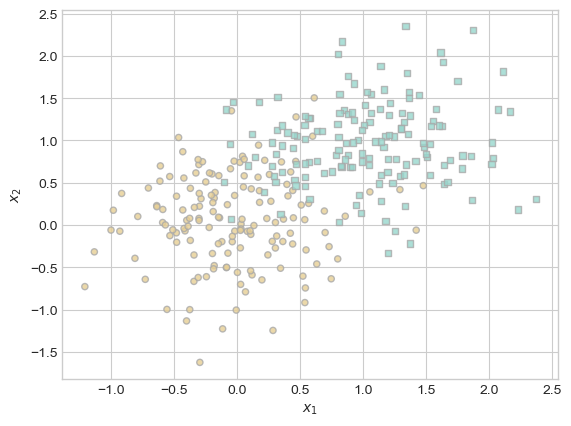

In [36]:
#| fig-cap: 'Data for logistic regression.'
#| fig-cap-location: margin
#| label: fig-LR-data
#| code-fold: true

fig, ax = plt.subplots(1, 1)
X, y = classification_data(noise = 0.5)
plot_classification_data(X, y, ax)

The code block below shows the training loop for a logistic regression model. This model *also* inherits from the `LinearModel` class that you previously started implementing. The training loop is also *very* similar to our training loop for the perceptron. The main difference is that the loss is calculated using the `binary_cross_entropy` function above, and the `step` function of the `GradientDescentOptimizer` works differently in a way that we will discuss in the following section. 

*Starting with the code block below, you won't be able to follow along in coding these notes unless you have sneakily implemented logistic regression in a `hidden` module.*


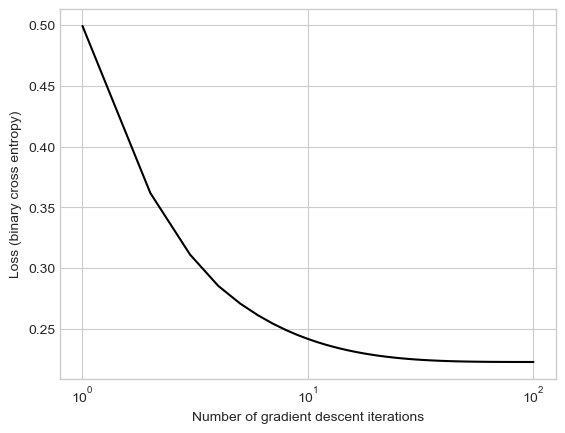

In [37]:
#| fig-cap: 'Evolution of the binary cross entropy loss function in the logistic regression training loop.'
#| fig-cap-location: margin
#| label: fig-LR-loss-iterations
#| code-fold: true

from hidden.logistic import LogisticRegression, GradientDescentOptimizer

# instantiate a model and an optimizer
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

# for keeping track of loss values
loss_vec = []

for _ in range(100):

    # not part of the update: just for tracking our progress    
    loss = LR.loss(X, y) 
    loss_vec.append(loss)

    # only this line actually changes the parameter value
    opt.step(X, y, lr = 0.02)

plt.plot(torch.arange(1, len(loss_vec)+1), loss_vec, color = "black")
plt.semilogx()
labs = plt.gca().set(xlabel = "Number of gradient descent iterations", ylabel = "Loss (binary cross entropy)")

The loss quickly levels out to a constant value. Because our theory tells us that the loss function is convex, we know that the value of $\mathbf{w}$ we have found is the best possible, in the sense of minimizing the loss. 

Let's take a look at the separating line we found: 


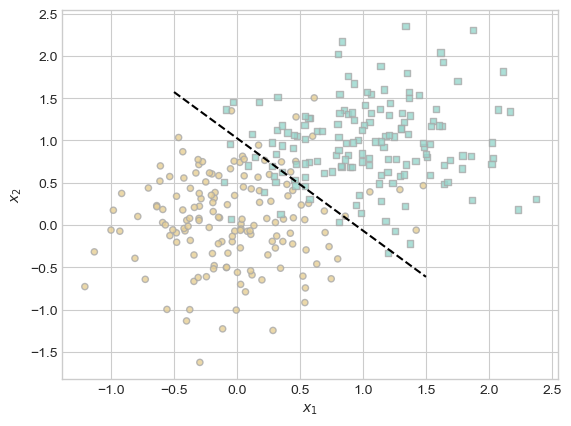

In [38]:
#| fig-cap: 'The separating line learned by logistic regression.'
#| fig-cap-location: margin
#| label: fig-LR-line
#| code-fold: true

def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

draw_line(LR.w, x_min = -0.5, x_max = 1.5, ax = ax, color = "black", linestyle = "dashed")

fig

Although our data is not linearly separable, the separating line we have learned appears to do a reasonable job of separating the points from each other. Let's check our accuracy: 


In [39]:
#---
(1.0*(LR.predict(X) == y)).mean()
#---

tensor(0.9067)

Not too bad! In the next section, we'll learn much, much more about what's behind that `opt.step()` call. 
